# FuseTS - S1 and S2 data fusion using MOGPR

In this notebook, we'll demonstrate how to use openEO's diverse capabilities to build a workflow for fusing data. In this particular case, we'll integrate both FuseTS's MOGPR service to fuse a datacube that contains multiple data sources. In this example, we'll be chosing Sentinel 2 NDVI and S1 Coherence data.

**Prerequisites**
- In this notebook, we utilize openEO to retrieve time series data. To leverage the full range of openEO features, you can create a free trial account on the [openEO Platform](https://docs.openeo.cloud/join/free_trial.html) and receive 1000 free credits, enabling you to execute the functionalities showcased in this notebook.


Lets start with importing the different libraries that we need within this notebook.


## Setting up the environment

First of all we need to make sure that all our dependencies are correctly installed.


In [1]:
!pip install openeo


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:

import warnings

import matplotlib.pyplot as plt
import numpy as np
import openeo
import pandas as pd
import xarray
from ipyleaflet import GeoJSON, Map, basemaps

warnings.filterwarnings("ignore")

# Exploring the area of interest
In this first part, we will explore the area of interest that will be used for calculating the phenology metrics.

In [3]:
year = 2023
spat_ext = {
    "type": "Polygon",
    "coordinates": [
        [
            [
                5.170012098271149,
                51.25062964728295
            ],
            [
                5.17085904378298,
                51.24882567194015
            ],
            [
                5.17857421368097,
                51.2468515482926
            ],
            [
                5.178972704726344,
                51.24982704376254
            ],
            [
                5.170012098271149,
                51.25062964728295
            ]
        ]
    ]
}
temp_ext = [f"{year}-01-01", f"{year}-03-01"]

Plot the area to see what we're working with.


In [4]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 16

m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m

Map(center=[51.249352711712234, 5.173686031746518], controls=(ZoomControl(options=['position', 'zoom_in_text',…

# Setting up connection with openEO

The first step in setting up the workflow, is creating a connection with openEO. 

In [5]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


# Executing the MOGPR function

In [7]:
service = 'mogpr_s1_s2'
namespace = 'u:fusets'

In [8]:
connection.describe_process(service, namespace=namespace)

{'description': '# Sentinel-1 and Sentinel-2 data fusion through multi output gaussian process regression\n\n## Description\n\nCompute a temporal dense timeseries based on the fusion of Sentinel-1 (S1) and Sentinel-2 (S2) using MOGPR. \n\n## Parameters\n| Name | Description                                                                   | Type | Default |\n|---|-------------------------------------------------------------------------------|---|---|\n| polygon | Polygon representing the AOI on which to apply the data fusion                | GeoJSON |   | \n| date | Date range for which to apply the data fusion                                 | Array |   |\n| s1_collection | S1 data collection to use for the fusion                                      | Text | RVI |\n| s2_collection | S2 data collection to use for fusing the data                                 | Text | NDVI | \n| include_uncertainties | Flag that indicated if the uncertainties should be included in the result     | Boolean | False | \n| include_raw_inputs | Flag that indicated if the raw input signals should be included in the result | Boolean | False | \n\n### Supported collections\n\n#### Sentinel-1\n\n* RVI ASC\n* RVI DESC\n* GRD ASC\n* GRD DESC\n* GAMMA0\n* COHERENCE (only Europe)\n\n#### Sentinel-2\n\n* NDVI\n* FAPAR\n* LAI\n* FCOVER\n* EVI\n* CCC\n* CWC\n\n\n## Usage\n\nUsage examples for the MOGPR process.\n\n### Python\n\nThis code example highlights the usage of the MOGPR process in an OpenEO batch job.\nThe result of this batch job will consist of individual GeoTIFF files per date.\nGenerating multiple GeoTIFF files as output is only possible in a batch job.\n\n```python\nimport openeo\n\n## Setup of parameters\nminx, miny, maxx, maxy = (15.179421073198585, 45.80924633589998, 15.185336903822831, 45.81302555710934)\nspat_ext = dict(west=minx, east=maxx, north=maxy, south=miny, crs=4326)\ntemp_ext = ["2021-01-01", "2021-12-31"]\n\n## Setup connection to openEO\nconnection = openeo.connect("openeo.vito.be").authenticate_oidc()\nservice = \'mogpr_s1_s2\'\nnamespace = \'u:fusets\'\n\nmogpr = connection.datacube_from_process(service,\n                                         namespace=f\'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}\',\n                                         polygon=spat_ext, date=temp_ext)\n\nmogpr.execute_batch(\'./result_mogpr_s1_s2.nc\', title=f\'FuseTS - MOGPR S1 S2\', job_options={\n    \'udf-dependency-archives\': [\n        \'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets_venv.zip#tmp/venv\',\n        \'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets.zip#tmp/venv_static\'\n    ],\n    \'executor-memory\': \'8g\'\n})\n\n```\n\n## Limitations\n\nThe spatial extent is limited to a maximum size equal to a Sentinel-2 MGRS tile (100 km x 100 km).\n\n## Configuration & Resource Usage\nThe executor memory defaults to 5 GB. You can increase the executor memory by specifying it as a job option, eg:\n\n```python\njob = cube.execute_batch(out_format="GTIFF", job_options={"executor-memory": "8g"})\n```\n',
 'id': 'mogpr_s1_s2',
 'parameters': [{'description': 'Polygon representing the AOI on which to apply the data fusion',
   'name': 'polygon',
   'schema': {'subtype': 'geojson', 'type': 'object'}},
  {'description': 'Date range for which to apply the data fusion',
   'name': 'date',
   'schema': {'examples': [['2015-01-01T00:00:00Z', '2016-01-01T00:00:00Z'],
     ['2015-01-01', '2016-01-01']],
    'items': {'anyOf': [{'format': 'date-time',
       'subtype': 'date-time',
       'type': 'string'},
      {'format': 'date', 'subtype': 'date', 'type': 'string'},
      {'maxLength': 4,
       'minLength': 4,
       'pattern': '^\\d{4}$',
       'subtype': 'year',
       'type': 'string'},
      {'type': 'null'}]},
    'maxItems': 2,
    'minItems': 2,
    'subtype': 'temporal-interval',
    'type': 'array'}},
  {'default': 'RVI ASC',
   'description': 'S1 data coll

In [9]:
mogpr = connection.datacube_from_process(service,
                                         namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}',
                                         polygon=spat_ext, date=temp_ext, s1_collection='RVI ASC', s2_collection='NDVI',
                                         include_uncertainties=True, include_raw_inputs=True)

# Downloading the results
Now that we've setup our workflow, we can now download the results by starting an openEO batch job.

In [10]:
mogpr_output_file = './mogpr-s1-s2.nc'

In [12]:
mogpr_job = mogpr.execute_batch(mogpr_output_file, out_format="netcdf",
                                title=f'FuseTS - MOGPR - S1/S2 Data Fusion', job_options={
        'executor-memory': '8g',
        'udf-dependency-archives': [
            'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets_venv.zip#tmp/venv',
            'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets.zip#tmp/venv_static'
        ]
    })

0:00:00 Job 'j-240306c902384df689b88b5554e2c868': send 'start'
0:00:26 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:00:31 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:00:38 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:00:46 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:00:56 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:01:08 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:01:24 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:01:44 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:02:08 Job 'j-240306c902384df689b88b5554e2c868': queued (progress N/A)
0:02:38 Job 'j-240306c902384df689b88b5554e2c868': running (progress N/A)
0:03:15 Job 'j-240306c902384df689b88b5554e2c868': running (progress N/A)
0:04:02 Job 'j-240306c902384df689b88b5554e2c868': running (progress N/A)
0:05:01 Job 'j-240306c902384df689b88b5554e2c868': running (progress N/

# Explore the results¶

In [15]:
cubes_dfs = []
ds = xarray.load_dataset(mogpr_output_file)
for var in ds.data_vars.items():
    if var[0] != 'crs':
        var_df = var[1].mean(dim=['x', 'y'])
        var_df = var_df.to_dataframe()
        var_df.index = pd.to_datetime(var_df.index)
        var_df['date'] = var_df.index.date
        var_df = var_df.set_index('date')
        cubes_dfs.append(var_df)

In [18]:
joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(
    columns={'NDVI': 'NDVI - Smoothed', 'RVI': 'RVI - Smoothed', 'unkown_band_2': 'RVI - Uncertainty',
             'unkown_band_3': 'NDVI - Uncertainty', 'unkown_band_4': 'RVI - Raw', 'unkown_band_5': 'NDVI - Raw'})

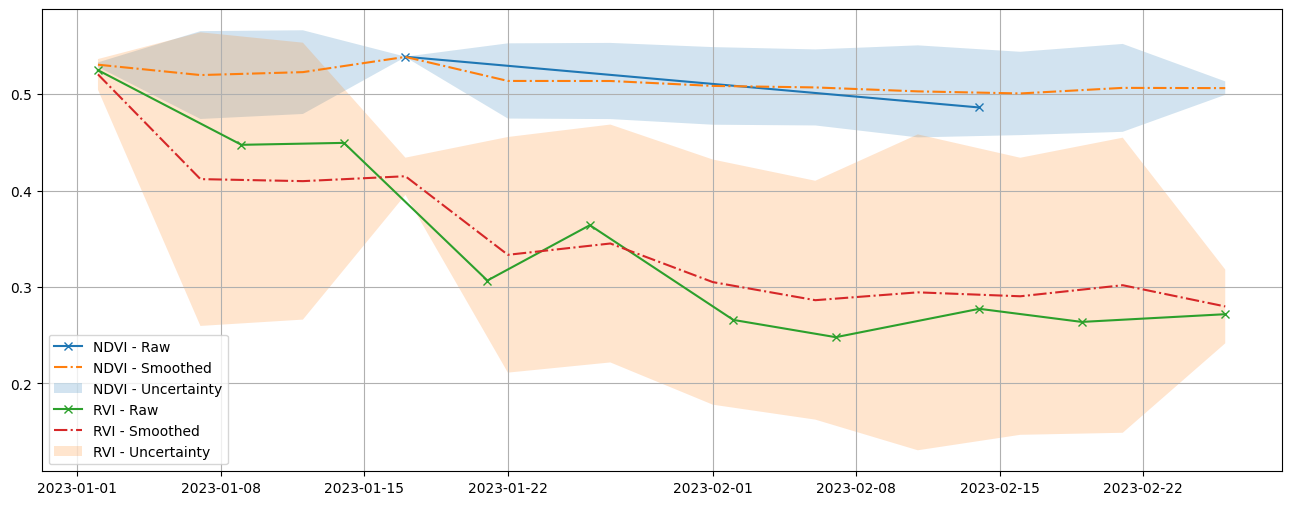

In [22]:
plt.figure(figsize=(16, 6))
std_col_mapping = {
    'NDVI - Uncertainty': 'NDVI - Smoothed',
    'RVI - Uncertainty': 'RVI - Smoothed'
}
for col in sorted(joined_df.columns.values):
    values = joined_df[~joined_df[col].isna()]
    if 'Uncertainty' in col:
        plt.fill_between(values.index, values[std_col_mapping[col]] - values[col],
                         values[std_col_mapping[col]] + values[col], alpha=0.2, label=col)
    elif 'Raw' in col:
        plt.plot(values.index, values[col], '-x' if 'Raw' in col else '-.', label=col)
    else:
        plt.plot(values.index, values[col], '.' if 'Raw' in col else '-.', label=col)
plt.grid(True)
plt.legend()